### Regresión Logística - Pair programming ###

## 2. Preprocesado ##

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


# Estandarización variables numéricas y Codificación variables categóricas
# -----------------------------------------------------------------------------
from sklearn.preprocessing import RobustScaler

# Gestión datos desbalanceados
# ------------------------------------------------------------------------------
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

# Para separar los datos en train y test
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split

#  Gestión de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

Usando el mismo dataset que usatéis ayer, los objetivos de los ejercicios de hoy son:

Estandarizar las variables numéricas de vuestro set de datos

Codificar las variables categóricas. Recordad que tendréis que tener en cuenta si vuestras variables tienen orden o no.

Chequear si vuestros datos están balanceados. En caso de que no lo estén utilizad algunas de las herramientas aprendidas en la lección para balancearlos.

Guardad el dataframe con los cambios que habéis aplicado para utilizarlo en la siguiente lección.

In [2]:
df = pd.read_pickle("data/card_limpio.pkl")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   distance_from_home              1000000 non-null  float64 
 1   distance_from_last_transaction  1000000 non-null  float64 
 2   ratio_to_median_purchase_price  1000000 non-null  float64 
 3   repeat_retailer                 1000000 non-null  category
 4   used_chip                       1000000 non-null  category
 5   used_pin_number                 1000000 non-null  category
 6   online_order                    1000000 non-null  category
 7   fraud                           1000000 non-null  category
dtypes: category(5), float64(3)
memory usage: 27.7 MB


Vamos a proceder a estandarizar los datos, como tenemos outliers lo haremos con el método RobustScaler.

In [3]:
numericas = df.select_dtypes(include = np.number)

In [4]:
# construir el modelo de escalador
robust = RobustScaler()

In [5]:
# ajustamos el modelo utilizando nuestro set de datos
robust.fit(numericas)

RobustScaler()

In [6]:
# transformamos los datos
X_robust = robust.transform(numericas)

In [7]:
numericas_robust = pd.DataFrame(X_robust, columns = numericas.columns)
numericas_robust.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
0,2.19108,-0.224744,0.585071
1,0.03943,-0.269055,0.182947


In [46]:
for columna in numericas_robust.columns:
    print(f'La media de la columna {columna} es:  {numericas_robust[columna].mean()}')
    print(f'La desviación estándar de la columna {columna} es: {numericas_robust[columna].std()}')
    print("-------------------------------------------------------------")

La media de la columna distance_from_home es:  0.7619614739979139
La desviación estándar de la columna distance_from_home es: 2.9905265247695496
-------------------------------------------------------------
La media de la columna distance_from_last_transaction es:  1.319963247166249
La desviación estándar de la columna distance_from_last_transaction es: 8.448003385926937
-------------------------------------------------------------
La media de la columna ratio_to_median_purchase_price es:  0.5099442223413461
La desviación estándar de la columna ratio_to_median_purchase_price es: 1.7273981508953737
-------------------------------------------------------------


KeyboardInterrupt: 

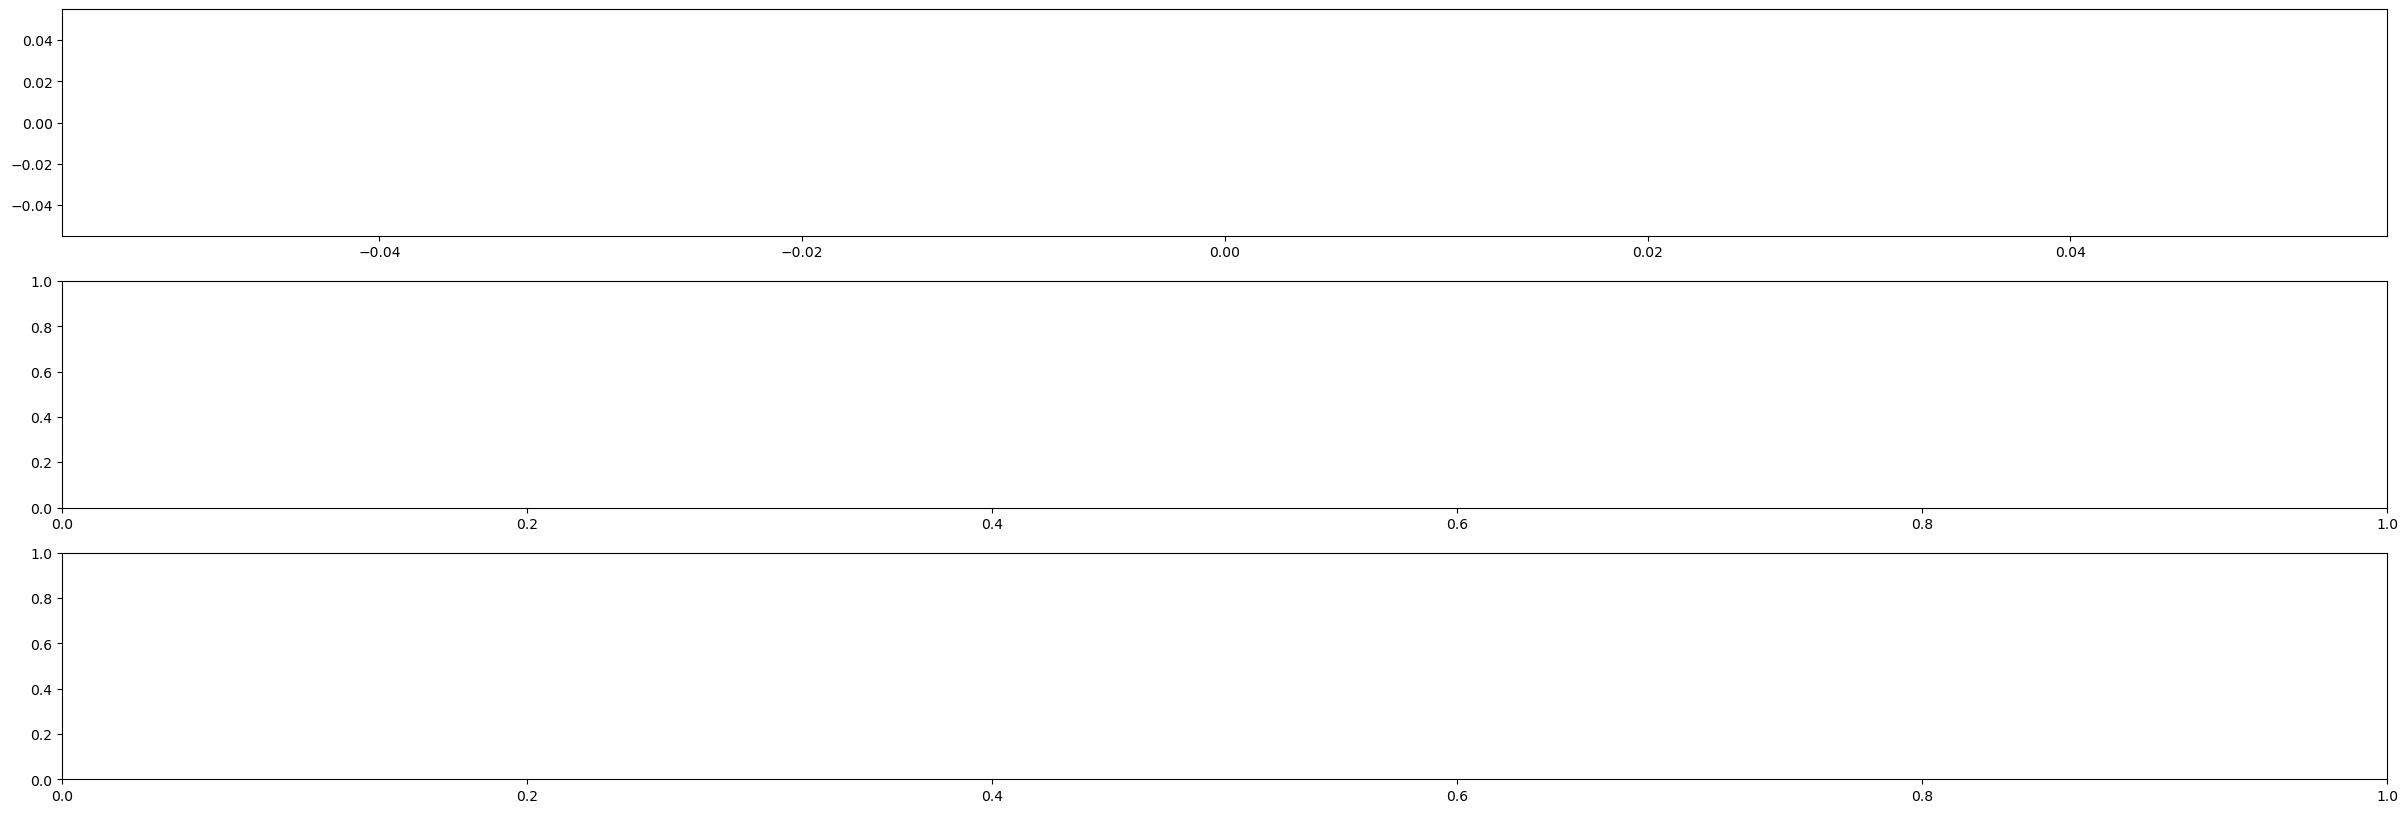

In [47]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (30, 10))

columnas_robust = numericas_robust.columns
axes = axes.flat


for i, colum in enumerate(columnas_robust): 
    sns.histplot(
        data = numericas_robust,
        x = colum,
        kde = True,  
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout()


In [8]:
df[numericas_robust.columns] = numericas_robust
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.191080,-0.224744,0.585071,1.0,1.0,0.0,0.0,0.0
1,0.039430,-0.269055,0.182947,1.0,0.0,0.0,0.0,0.0
2,-0.223026,-0.063254,-0.351702,1.0,0.0,0.0,1.0,0.0
3,-0.353069,1.504177,-0.391840,1.0,1.0,0.0,1.0,0.0
4,1.565134,-0.141273,0.755879,1.0,1.0,0.0,1.0,0.0


Procedemos a hacer el encoding de las variables categóricas. Vamos a ver el orden:

    - repeat_retailer	**SI** tiene orden
    - used_chip	    **SI** tiene orden
    - used_pin_number	**NO** tiene orden
    - online_order  **SI** tiene orden

Entonces las columnas que tienen orden las dejamos como están puesto que son binarias, y la columna que no tiene orden (used_pin_number) le vamos a aplicar get_dummies.

In [49]:
# dummies = pd.get_dummies(df["used_pin_number"], prefix_sep = "_", prefix = "used_pin_number", dtype = int)
# dummies.head(2)

In [50]:
# df_est_enc = pd.concat([df, dummies], axis = 1)
# df_est_enc.drop('used_pin_number', axis = 1, inplace= True)

In [51]:
# df_est_enc.head()

In [9]:
df.to_pickle('data/card_est_enc.pkl')

In [10]:
# para aplicar este método lo primero que tenemos que hacer es separar en X e y y en train y test como aprendimos en la lecciones de regresion lineal
y = df['fraud']
X = df.drop('fraud', axis=1)


#dividimos en sets de entrenamiento y test
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [11]:
# iniciamos el método
os_us = SMOTETomek()

# ajustamos el modelo
X_train_res, y_train_res = os_us.fit_resample(X, y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [13]:
y_train.value_counts()

0.0    638879
1.0     61121
Name: fraud, dtype: int64

In [14]:
y_train_res.value_counts()

0.0    912559
1.0    912559
Name: fraud, dtype: int64

In [15]:
# comprobemos como han quedado ahora las categorías después del ajuste

print (f"Distribution before resampling \n {y_train.value_counts()}" )
print("..............................................................")
print (f"Distribución después del ajuste \n {y_train_res.value_counts()}")

Distribution before resampling 
 0.0    638879
1.0     61121
Name: fraud, dtype: int64
..............................................................
Distribución después del ajuste 
 0.0    912559
1.0    912559
Name: fraud, dtype: int64


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   distance_from_home              1000000 non-null  float64 
 1   distance_from_last_transaction  1000000 non-null  float64 
 2   ratio_to_median_purchase_price  1000000 non-null  float64 
 3   repeat_retailer                 1000000 non-null  category
 4   used_chip                       1000000 non-null  category
 5   used_pin_number                 1000000 non-null  category
 6   online_order                    1000000 non-null  category
 7   fraud                           1000000 non-null  category
dtypes: category(5), float64(3)
memory usage: 27.7 MB


In [17]:
y_train_res.shape

(1825118,)

In [18]:
y_train_res.shape

(1825118,)

In [19]:
X_train_res.isnull().sum()

distance_from_home                   0
distance_from_last_transaction       0
ratio_to_median_purchase_price       0
repeat_retailer                   3340
used_chip                         9387
used_pin_number                   1667
online_order                      7604
dtype: int64

In [21]:
df_balanceo = pd.concat([y_train_res, X_train_res], axis = 1)

In [22]:
df_balanceo.isnull().sum()

fraud                                0
distance_from_home                   0
distance_from_last_transaction       0
ratio_to_median_purchase_price       0
repeat_retailer                   3340
used_chip                         9387
used_pin_number                   1667
online_order                      7604
dtype: int64

In [23]:
 df_balanceo.dropna(inplace = True)

In [24]:
df_balanceo['fraud'].value_counts()

0.0    912559
1.0    893983
Name: fraud, dtype: int64

In [25]:
df_balanceo.to_pickle('data/df_balanceo.pkl')